# Prova sense definir la 2a funció...

Number of unknowns: 6
Number of equations: 6
(<dedalus.core.subsystems.Subproblem object at 0x12cb88710>,)
2025-04-23 09:47:05,393 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.7e-01/s
evals.size (before)  260
evals.size (after removing inf)  252
evals.size (after removing < 0)  252

evals size 252
true_evals size  252
First 5 Eigenvalues (sqrt): [ 2.62441261  5.86836499  7.53737967  9.29494714 13.71111477]
First 5 True eigenvalues: [ 2.66901857  7.55178196  9.34725317 13.9452195  16.96084541]
Relative error: [0.0167125  0.22291652 0.19362624 0.33346713 0.19160193]
(-0.0011036133235221616+6.928321553848907e-06j)
0j
(-0.002819516004403529-0.000299408415795489j)
(0.003785047335354162+0.0002135061321399847j)
(-0.005372703309052323-0.0016563276286796864j)


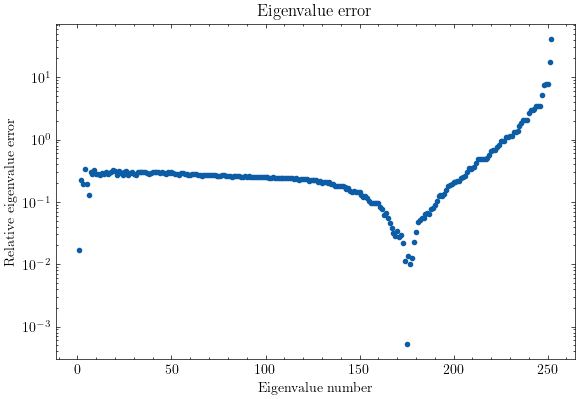

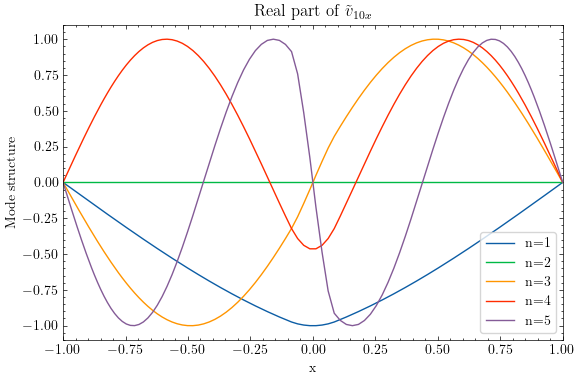

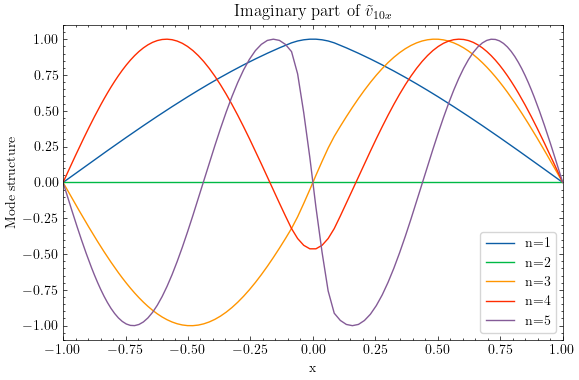

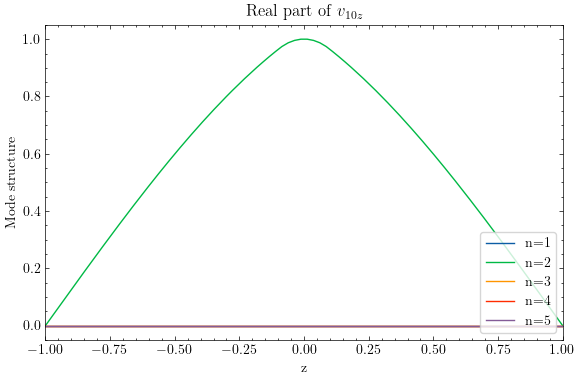

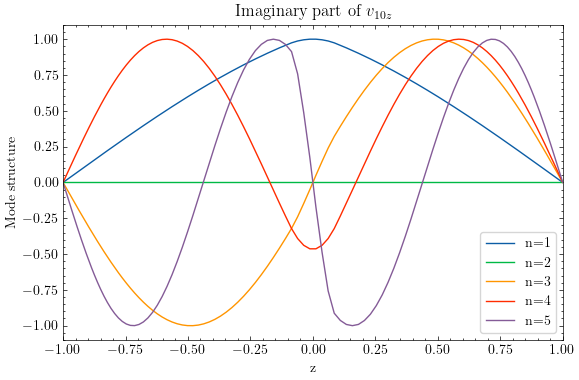

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
logger = logging.getLogger(__name__)
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

#def dispersion_relation2(omega):
#    disprel_even2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
#        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
#    disprel_odd2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
#        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
#    disprel2 = disprel_even2 * disprel_odd2
#    return disprel2

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
#        sol2 = fsolve(dispersion_relation2, omega0)

        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
#        if sol2 > 0:
#            exact_soln = np.append(exact_soln, sol2)
#            exact_soln = np.unique(exact_soln.round(decimals=8))

        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
#    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln

# Crec que la sol2 no està fent res perque els valors de vA2 són molt més grans que els de c2...
# Aquí es demostra que sí que fa alguna cosa ja que l'error relatiu és diferent. Per tant, els autovalors "reals" són diferents. Quins són els bons?
# Jo crec que els bons són els obtinguts amb les dues "disprel" ja que així també tenim en compte vA2, sinó ho ignoram per complet!

# En el cas de kz = 0 hauríem de recuperar els resultats de la corda amb densitat variable!
# No ens serveix si kz != 0...





""" Paràmetres """
Nx = 128 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]
# Square of the wave velocity in the two parts of the system.
cp2 = 1
cc2 = 6
vAp2 = 5
vAc2 = 30
# And the Alfvén speed too.


""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ### --- autofuncions?
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis) # PUNTS DEL DOMINI!!!

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.
#kz = dist.Field(name='kz', bases=xbasis) # kz = Wave number in the z direction
#kz['g'] = 0 # Representa el nombre d'ona en la direcció z en l'espai real ('g').
#kz['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [0, 0, 0]) # Representa el nombre d'ona en la direcció z en l'espai real ('g') a trossos.
kz = 0
B0 = 0


### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Camps magnètics ###
Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z
#B0 = dist.Field(name='B0', bases=xbasis) # B0 = Constant magnetic

### Densitats ###
rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma  ρ0
rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.
# Definir bé la densitat...

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')
# tau_5 = dist.Field(name='tau_5')


""" Substitucions """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
#rho10x = dx(rho10) +  lift(tau_5) # First-order reduction of the density variation ### realment no és necessari ja que amb l'ajuda de l'equació (12) s'elimina aquesta derivada.

# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!



# RESOLDRE PRIMER SUBSTITUINT BX, BZ i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w --- FET



# tenim v_alfven i cp que primer constants i després piecewice


# velocitat dedins menor que defora
# alfven major primer, després provar

# comparar amb kz = 0 les dues equacions han de ser iguals!! recuperam el cas alfven? la de alfven és com la corda directament amb densitat no const.
# provar amb kz = 0.01 i s'ha de modificar poc


""" Problem """
# Problema d'ones ràpides i lentes
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

# 2 equacions i 4 incògnites
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals())

# Problema d'ones d'Alfvén ~ corda guitarra amb densitat variable
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)
# problem.add_equation("s * u  +  c2 * uxx  =  0") # (17') # amb kz = 0
# problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0. Hauríem d'obtenir una molt semblant a la (17') però amb la velocitat en z i la constant d'Alfvén
problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")

# Obtenc el mateix que quan no hi havia la kz
# Perquè no em representa tots els modes? Diu que divideix entre 0...? Hauria de recuperar 2 casos de la corda diferents: amb "densitat" variable i amb "densitat" d'Alfvén.


# Falten definir les equacions de la densitat, el camp magnètic, la velocitat, etc. Per això dona error.
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))
#print("Eivdentment no es pot resoldre el problema amb 3 equacions i 8 incògnites.")



""" Solve """
solver = problem.build_solver()
print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

print('evals.size (before) ', evals.size)
evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

# Autovalors exactes
# Get the first (i.e. positive) Nevals eigenvalues.
Nevals = np.rint(Nx*2).astype(int) # round integer, convert to integer; agafam 2*Nx per obtenir 264 autovalors ---> alternativa: Nevals = evals.size
#Nevals = evals.size
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
true_evals = exact_soln[0:evals.size] # és que aquí ja està tallant els autovalors que dius que no has de tallar!
# true_evals = (n * np.pi / 2*xmax)**2 # vàlid per densitat constant
relative_error = np.abs(evals - true_evals) / true_evals

print('evals size', evals.size)
print("true_evals size ", true_evals.size)
#print("Evals", evals)
#print("True Evals", true_evals)

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])



""" Plot """
# Plot error
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Eigenvalue number")
plt.ylabel("Relative eigenvalue error")
plt.tight_layout()
plt.title("Eigenvalue error")
#plt.savefig("eigenvalue_error.pdf")
#plt.savefig("eigenvalue_error.png", dpi=200)


# Plot real part of v10x
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis) # no acab d'entendre perquè es repeteix el domini... per si l'has tuneat penmig maybe
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real
    if np.max(np.abs(ug)) != 0:  # Avoid division by zero
        ug /= np.max(np.abs(ug))

    #ug = (u['g']).real / (u['g'][1]).real
    print(u['g'][1])
    plt.plot(x, ug, label=f"n={n}")
    #plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}") # quan es normalitza es divideix per zero... pq hi ha una autofunció nul·la?
plt.xlim(-1, 1)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"x")
plt.title(r"Real part of $\tilde{v}_{10x}$") # idò és imaginària ---> desfassament temporal de 1/4 de període
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)

# Plot imaginary part of v10x
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    # if u['g'][1] != 0:
        # ui = (u['g'] / u['g'][1]).imag
    # else:
        # ui = u['g'].imag  # Skip normalization

    ui = u['g'].imag
    if np.max(np.abs(ui)) != 0:  # Avoid division by zero
        ui /= np.max(np.abs(ui)) # Normalitzam per la part real (ug), que és molt major i no ens resulta en la mateixa autofunció

    plt.plot(x, ui, label=f"n={n}")

    # ug = (u['g'] / u['g'][1]).real
    # ui = (u['g'] / u['g'][1]).imag
    # plt.plot(x, ui/np.max(np.abs(ug)), label=f"n={n}") # no normalitzam pq ens divideix per 0 ### ara sí normalitzam

    #ui = (u['g'] / u['g'][1]).imag
    #plt.plot(x, ui/np.max(np.abs(ui)), label=f"n={n}")
plt.xlim(-1, 1)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"x")
plt.title(r"Imaginary part of $\tilde{v}_{10x}$") # idò és real ---> desfassament temporal de 1/4 de període
plt.tight_layout()
# plt.savefig("imag_eigenvectors.pdf")
# plt.savefig("imag_eigenvectors.png", dpi=200)

# Plot real part of v10z
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    #wg = (w['g'] / w['g'][1]).real
    wg = w['g'].real
    if np.max(np.abs(wg)) != 0:  # Avoid division by zero
        wg /= np.max(np.abs(wg))
    plt.plot(x, wg, label=f"n={n}")
    #plt.plot(x, wg/np.max(np.abs(wg)), label=f"n={n}")
plt.xlim(-1, 1)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"z")
plt.title(r"Real part of ${v}_{10z}$")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)

# Plot real part of v10z
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    wi = u['g'].imag
    if np.max(np.abs(wi)) != 0:  # Avoid division by zero
        wi /= np.max(np.abs(wi)) # Normalitzam per la part real (wg), que és molt major i no ens resulta en la mateixa autofunció

    plt.plot(x, wi, label=f"n={n}")

    #plt.plot(x, wi/np.max(np.abs(wg)), label=f"n={n}")
plt.xlim(-1, 1)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"z")
plt.title(r"Imaginary part of ${v}_{10z}$")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)


# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z. També que v10x és imaginària i v10z és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.

